# Load and visualize models

Install prerequisites:

```bash
# huggingface transformers
pip install transformers

# visualizer
conda install -y graphviz python-graphviz
pip install torchlens
```


In [1]:
import torch
from torchvision.models import ResNet18_Weights
from torchvision import models

from torchview import draw_graph
import torchlens as tl


/scratch2/gings/software/mambaforge/envs/cvenv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/scratch2/gings/software/mambaforge/envs/cvenv/lib/python3.9/site-packages/torch/overrides.py:110: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  torch.has_cuda,
/scratch2/gings/software/mambaforge/envs/cvenv/lib/python3.9/site-packages/torch/overrides.py:111: UserWarning: 'has_cudnn' is deprecated, please use 'torch.backends.cudnn.is_available()'
  torch.has_cudnn,
/scratch2/gings/software/mambaforge/envs/cvenv/lib/python3.9/site-packages/torch/overrides.py:117: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  torch.has_mps,
/scratch2/gings/software/mambaforge/envs/cvenv/lib/python3.9/site-packages/torch/overrides.py:118: UserWarning: 'has

## ResNet18

In [2]:
model: models.resnet.ResNet = models.resnet18(
    weights=ResNet18_Weights.IMAGENET1K_V1
)


In [3]:
help(tl.log_forward_pass)

Help on function log_forward_pass in module torchlens.user_funcs:

log_forward_pass(model: torch.nn.modules.module.Module, input_args: Union[torch.Tensor, List[Any], Tuple[Any]], input_kwargs: Dict[Any, Any] = None, layers_to_save: Union[str, List, NoneType] = 'all', keep_unsaved_layers: bool = True, output_device: str = 'same', activation_postfunc: Optional[Callable] = None, mark_input_output_distances: bool = False, detach_saved_tensors: bool = False, save_function_args: bool = False, save_gradients: bool = False, vis_opt: str = 'none', vis_nesting_depth: int = 1000, vis_outpath: str = 'graph.gv', vis_save_only: bool = False, vis_fileformat: str = 'pdf', vis_buffer_layers: bool = False, vis_direction: str = 'bottomup', random_seed: Optional[int] = None) -> torchlens.model_history.ModelHistory
    Runs a forward pass through a model given input x, and returns a ModelHistory object containing a log
    (layer activations and accompanying layer metadata) of the forward pass for all laye

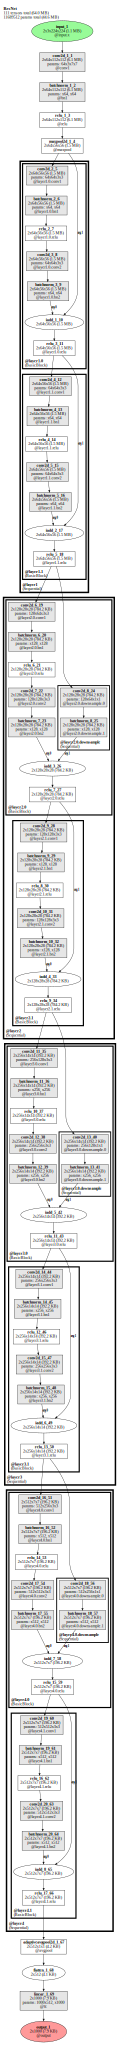

Log of ResNet forward pass:
	Random seed: 1882545502
	Time elapsed: 13.979s (13.891s spent logging)
	Structure:
		- purely feedforward, no recurrence
		- with branching
		- no conditional (if-then) branching
		- contains 40 buffer layers
		- 67 total modules
	Tensor info:
		- 111 total tensors (64.0 MB) computed in forward pass.
		- 111 tensors (64.0 MB) with saved activations.
	Parameters: 41 parameter operations (11689512 params total; 44.6 MB)
	Module Hierarchy:
		conv1
		bn1
		relu
		maxpool
		layer1
		    layer1.0
		        layer1.0.conv1, layer1.0.bn1, layer1.0.relu:1, layer1.0.conv2, layer1.0.bn2, layer1.0.relu:2
		    layer1.1
		        layer1.1.conv1, layer1.1.bn1, layer1.1.relu:1, layer1.1.conv2, layer1.1.bn2, layer1.1.relu:2
		layer2
		    layer2.0
		        layer2.0.conv1
		        layer2.0.bn1
		        layer2.0.relu:1
		        layer2.0.conv2
		        layer2.0.bn2
		        layer2.0.downsample
		            layer2.0.downsample.0, layer2.0.downsample.1
		        layer2.0.

In [4]:
model_history  = tl.log_forward_pass(
    model, torch.zeros((2, 3, 224, 224)), 
    vis_opt="rolled",
    vis_direction="topdown",
    vis_fileformat="svg",
    vis_outpath="resnet18.svg",
)
print(model_history)

## VisionTransformer

In [5]:
from transformers import AutoImageProcessor, AutoModelForImageClassification

processor = AutoImageProcessor.from_pretrained("WinKawaks/vit-small-patch16-224")
vit_model = AutoModelForImageClassification.from_pretrained("WinKawaks/vit-small-patch16-224")


In [6]:
for k, v in vit_model.config.to_dict().items():
    if k in ["label2id", "id2label"]:
        print(f"{k:40s}: length {len(v)}")
        continue
    print(f"{k:40s}: {v}")

return_dict                             : True
output_hidden_states                    : False
output_attentions                       : False
torchscript                             : False
torch_dtype                             : float32
use_bfloat16                            : False
tf_legacy_loss                          : False
pruned_heads                            : {}
tie_word_embeddings                     : True
is_encoder_decoder                      : False
is_decoder                              : False
cross_attention_hidden_size             : None
add_cross_attention                     : False
tie_encoder_decoder                     : False
max_length                              : 20
min_length                              : 0
do_sample                               : False
early_stopping                          : False
num_beams                               : 1
num_beam_groups                         : 1
diversity_penalty                       : 0.0
temperature  

Inspect the model code to find out where the positional encoding is added, since that is not obvious from the model graph output.

Turns position encodings are learned weights that are added at the end of `vit_model.vit.embeddings.forward`

In the graph they show up as `add_1_6 params 1x197x384`:

Sequence length is 197 = 1 Learned "CLS" token + 14x14 positional embeddings.


In [7]:
import inspect

print(inspect.getsource(vit_model.forward))
print("========================================================")
print(inspect.getsource(vit_model.vit.forward))
print("========================================================")
print(inspect.getsource(vit_model.vit.embeddings.forward))
print("========================================================")
print(vit_model.vit.embeddings.position_embeddings)

    @add_start_docstrings_to_model_forward(VIT_INPUTS_DOCSTRING)
    @add_code_sample_docstrings(
        checkpoint=_IMAGE_CLASS_CHECKPOINT,
        output_type=ImageClassifierOutput,
        config_class=_CONFIG_FOR_DOC,
        expected_output=_IMAGE_CLASS_EXPECTED_OUTPUT,
    )
    def forward(
        self,
        pixel_values: Optional[torch.Tensor] = None,
        head_mask: Optional[torch.Tensor] = None,
        labels: Optional[torch.Tensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        interpolate_pos_encoding: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[tuple, ImageClassifierOutput]:
        r"""
        labels (`torch.LongTensor` of shape `(batch_size,)`, *optional*):
            Labels for computing the image classification/regression loss. Indices should be in `[0, ...,
            config.num_labels - 1]`. If `config.num_labels == 1` a regression loss is compute

In [8]:
vit_model

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=3

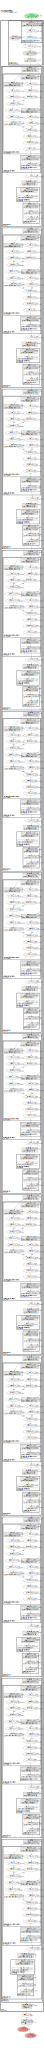

Log of ViTForImageClassification forward pass:
	Random seed: 3014164378
	Time elapsed: 29.237s (29.04s spent logging)
	Structure:
		- purely feedforward, no recurrence
		- with branching
		- no conditional (if-then) branching
		- 224 total modules
	Tensor info:
		- 349 total tensors (298.3 MB) computed in forward pass.
		- 349 tensors (298.3 MB) with saved activations.
	Parameters: 101 parameter operations (22050664 params total; 84.1 MB)
	Module Hierarchy:
		vit
		    vit.embeddings
		        vit.embeddings.patch_embeddings
		            vit.embeddings.patch_embeddings.projection
		        vit.embeddings.dropout
		    vit.encoder
		        vit.encoder.layer.0
		            vit.encoder.layer.0.layernorm_before
		            vit.encoder.layer.0.attention
		                vit.encoder.layer.0.attention.attention
		                    vit.encoder.layer.0.attention.attention.query, vit.encoder.layer.0.attention.attention.key, vit.encoder.layer.0.attention.attention.value, vit.encoder.layer

In [9]:
model_history  = tl.log_forward_pass(
    vit_model, torch.zeros((2, 3, 224, 224)), 
    vis_opt="unrolled",
    vis_direction="topdown",
    vis_fileformat="svg",
    vis_outpath="vit_small.svg",
    vis_nesting_depth=99,
)
print(model_history)

## Generative Language Transformer

With one forward pass we can generate one token ("word") at a time.

Here: "Hello my name" -> model -> " is"

For a longer output you would loop. Huggingface allows this functionality with `model.generate`

Notes: Importantly for a batch of text with varying input length you would need to properly pad (pad left side for generative transformers) and pass attention_mask to mask the padding tokens.


In the graph you can see the embedding consists of a language embedding (50257x768) which maps from tokens to embeddings (the tokenizer before mapped text to tokens) and a position embedding (1024x768) from which only the first 3 positions are used.

In [10]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained("distilgpt2")
model = AutoModelForCausalLM.from_pretrained("distilgpt2")

tokens = tokenizer("Hello my name", return_tensors="pt")
output_logits = model(tokens.input_ids).logits

print(output_logits.shape)


torch.Size([1, 3, 50257])


In [11]:
greedy_decoding = output_logits.argmax(-1)
tokenizer.decode(greedy_decoding[0, -1], skip_special_tokens=False)

' is'

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


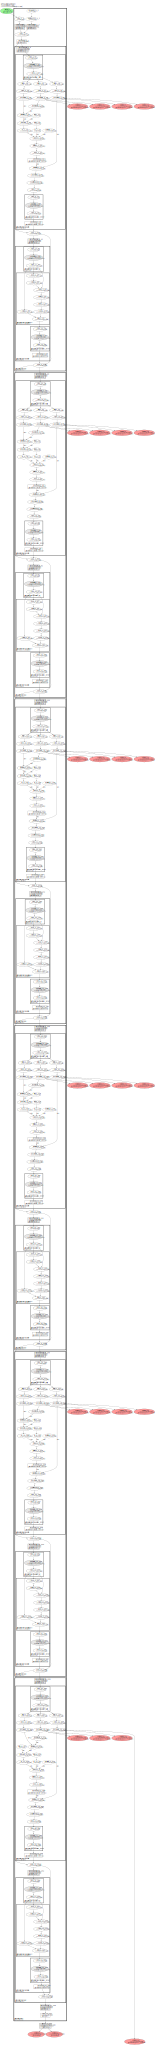

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Log of GPT2LMHeadModel forward pass:
	Random seed: 2095445668
	Time elapsed: 24.413s (24.352s spent logging)
	Structure:
		- recurrent (at most 2 loops)
		- with branching
		- no conditional (if-then) branching
		- contains 6 buffer layers
		- 84 total modules
	Tensor info:
		- 349 total tensors (12.1 MB) computed in forward pass.
		- 349 tensors (12.1 MB) with saved activations.
	Parameters: 40 parameter operations (120509952 params total; 459.7 MB)
	Module Hierarchy:
		transformer
		    transformer.wte
		    transformer.wpe
		    transformer.drop
		    transformer.h.0
		        transformer.h.0.ln_1
		        transformer.h.0.attn
		            transformer.h.0.attn.c_attn, transformer.h.0.attn.attn_dropout, transformer.h.0.attn.c_proj, transformer.h.0.attn.resid_dropout
		        transformer.h.0.ln_2
		        transformer.h.0.mlp
		            transformer.h.0.mlp.c_fc, transformer.h.0.mlp.act, transformer.h.0.mlp.c_proj, transformer.h.0.mlp.dropout
		    transformer.h.1
		        trans

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [12]:
model_history  = tl.log_forward_pass(
    model, 
    tokens.input_ids, 
    vis_opt="unrolled",
    vis_direction="topdown",
    vis_fileformat="svg",
    vis_nesting_depth=99,
    vis_outpath="distilgpt2.svg",
)
print(model_history)